##  End-to-End E-Commerce Business Performance Analysis [Case-Study]
---
**Author:** Jaiwardhan Singh  
**Tools Used:** Python (Pandas, NumPy, Matplotlib)

This notebook presents an end-to-end analysis of revenue performance,
customer behavior, logistics efficiency and geographic insights using transactional multi-schema E-commerce data.

##  ► Data loading
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
customers = pd.read_csv("D:\Python project 1\Data tables\Customers.csv")
orders = pd.read_csv("D:\Python project 1\Data tables\Orders.csv")
order_items = pd.read_csv("D:\Python project 1\Data tables\Order items.csv")

## ► Data Cleaning & Verification
---

In [ ]:
# Data cleaning for customer table
customers.columns
customers.drop(columns = ['Unnamed: 5', 'Unnamed: 6'])
customers.head()
customers.dtypes
customers.duplicated().sum()
customers.isnull().sum()

# Data cleaning for orders table
orders.head()
orders.dtypes
orders.isnull().sum ()
orders[orders['order_delivered_customer_date'].isnull()]['order_status'].value_counts()
# Not dropping null values because the nulls have business logic
orders.duplicated().sum()

# Data cleaning for order items table
order_items.head()
orders.dtypes
order_items.isna().sum()
order_items.duplicated().sum()

## ► Data Preparation
---

In [ ]:
# Date Conversions

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
# orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], dayfirst=True, errors='coerce')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
print(orders['order_purchase_timestamp'].dtype)
print(orders['order_delivered_customer_date'].dtype)
print(orders['order_estimated_delivery_date'].dtype)

# Creating Columns & Flags

order_items['total_revenue'] = order_items['price'] + order_items['freight_value']
print(order_items['total_revenue'].head())

delivered_orders = orders[orders['order_status'] == 'delivered'].copy()
delivered_orders['is late'] = (delivered_orders['order_delivered_customer_date'] > delivered_orders['order_estimated_delivery_date'])
print(delivered_orders['is late'].head())

# Mapping 

state_map = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapa',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceara',
    'DF': 'Distrito Federal',
    'ES': 'Espirito Santo',
    'GO': 'Goias',
    'MA': 'Maranhao',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Para',
    'PB': 'Paraiba',
    'PR': 'Parana',
    'PE': 'Pernambuco',
    'PI': 'Piaui',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondonia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'Sao Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'
}

## ► Analysis and Visualizations
---
### ◆ What is the Monthly Revenue Trend?
---
This analysis evaluates overall business growth by examining monthly revenue performance and Month-over-Month (MoM) growth trends.

In [21]:
# Merge required tables
df = orders.merge(order_items, on = 'order_id', how = 'left')
# Create total revenue column
df['monthly_revenue'] = df['price'] + df['freight_value']
# Convert purchase timestamp
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
# Extract month
df['month'] = df['order_purchase_timestamp'].dt.to_period('M')
# Calculate monthly revenue and MoM growth
monthly_revenue = (df.groupby('month')['monthly_revenue'].sum().reset_index().sort_values('month'))
monthly_revenue['MOM_growth%'] = (monthly_revenue['monthly_revenue'].pct_change().mul(100).round(2))
print(monthly_revenue.head()) 

     month  monthly_revenue  MOM_growth%
0  2016-09           354.75          NaN
1  2016-10         56808.84     15913.77
2  2016-12            19.62       -99.97
3  2017-01        137188.49    699127.78
4  2017-02        286280.62       108.68


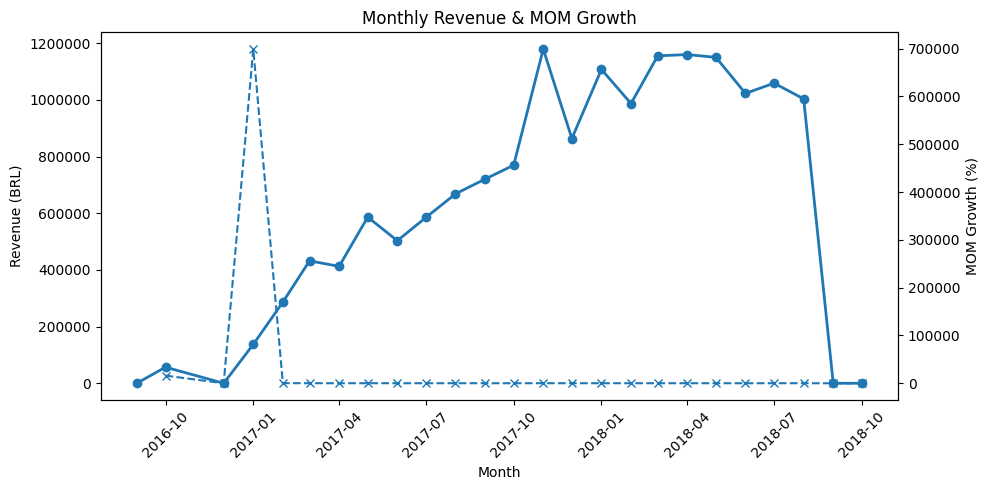

In [22]:
# Visualization 

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(monthly_revenue['month'].dt.to_timestamp(),
monthly_revenue['monthly_revenue'], marker = 'o', linewidth = 2)
ax1.set_xlabel("Month")
ax1.set_ylabel("Revenue (BRL)")
ax1.ticklabel_format(style = 'plain', axis = 'y')
ax1.tick_params(axis = 'x', rotation = 45)
ax2 = ax1.twinx()
ax2.plot(monthly_revenue['month'].dt.to_timestamp(),
monthly_revenue['MOM_growth%'], linestyle = '--', marker = 'x')
ax2.set_ylabel("MOM Growth (%)")
plt.title("Monthly Revenue & MOM Growth")
plt.tight_layout()
plt.show()

### ➔ Insights
---
Monthly revenue demonstrates consistent growth over time, with identifiable peak periods suggesting seasonal demand effects.
MoM growth analysis reveals expansion phases followed by stabilization, indicating improving revenue maturity as the business scales.

### ➔ Strategic implication
---
Seasonal revenue spikes present opportunities for targeted promotions and inventory optimization. Sustained growth suggests expanding customer engagement and operational stability.

### ◆ What is the Average Order Value?
---
This analysis measures the average revenue generated per completed order,
providing insight into transaction-level monetization efficiency.

In [27]:
# Merge order_items with orders
df = order_items.merge(orders, on='order_id', how='left')
# Create total revenue per row
df['total_revenue'] = df['price'] + df['freight_value']
# Calculate total revenue per order
revenue_per_order = (df.groupby('order_id')['total_revenue'].sum().reset_index())
# Calculate Average Order Value
AOV = revenue_per_order['total_revenue'].mean()
print(AOV)

160.57763809214924


### ➔ Insights
---
The Average Order Value (AOV) is approximately **160.57 BRL**,
indicating the average revenue generated per completed transaction.

### ◆ What Percentage of Revenue Comes from the Top 20% of Customers? (Pareto Analysis — 80/20 rule)
---
This analysis evaluates revenue concentration by identifying how much 
total revenue is generated by the top 20% highest-spending customers.

In [29]:
# Merge all required tables
df = order_items.merge(orders, on='order_id', how='left')
df = df.merge(customers, on='customer_id', how='left')
# Create total revenue column
df['total_revenue'] = df['price'] + df['freight_value']
# Calculate total revenue per customer
revenue_per_customer = (df.groupby('customer_unique_id')['total_revenue'].sum().reset_index())
# Sort customers by revenue (descending)
revenue_per_customer = revenue_per_customer.sort_values('total_revenue', ascending=False).reset_index(drop=True)
# Determine top 20% cutoff
top_20_count = int(len(revenue_per_customer) * 0.20)
# Calculate revenue contribution of top 20%
top_20_revenue = revenue_per_customer.head(top_20_count)['total_revenue'].sum()
total_revenue = revenue_per_customer['total_revenue'].sum()
top_20_percentage = (top_20_revenue / total_revenue) * 100
print(top_20_percentage)

53.66147493060718


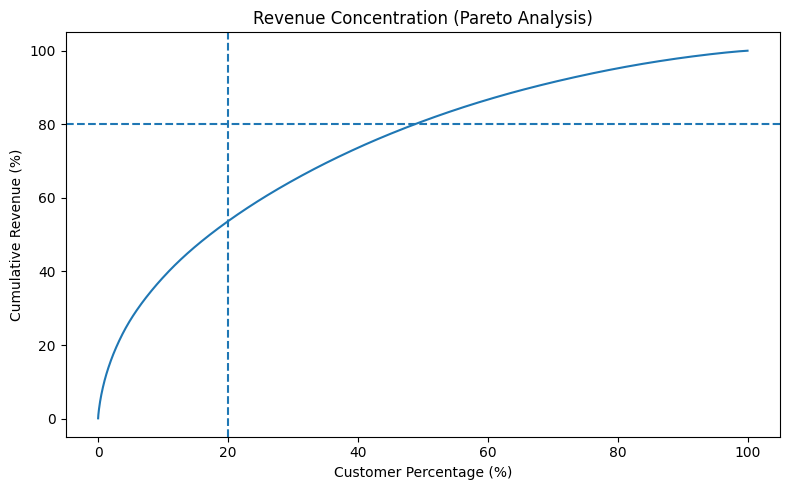

In [ ]:
# Visualization 

revenue_per_customer['cumulative_revenue_%'] = (revenue_per_customer['total_revenue'].cumsum() /
revenue_per_customer['total_revenue'].sum()) * 100
customer_percent = (np.arange(1, len(revenue_per_customer)+1) / len(revenue_per_customer)) * 100
plt.figure(figsize=(8,5))
plt.plot(customer_percent, revenue_per_customer['cumulative_revenue_%'])
plt.axvline(x=20, linestyle='--')
plt.axhline(y=80, linestyle='--')
plt.xlabel("Customer Percentage (%)")
plt.ylabel("Cumulative Revenue (%)")
plt.title("Revenue Concentration (Pareto Analysis)")
plt.tight_layout()
plt.show()

### ➔ Insights
---
The top 20% of customers contribute approximately **54% of total revenue**, 
indicating moderate revenue concentration.
While not a strict 80/20 Pareto distribution, a relatively small segment 
of high-value customers drives more than half of overall revenue.

### ➔ Strategic Implication
---
Strengthening retention efforts for high-value customers while 
developing mid-tier customers can enhance revenue stability 
and long-term growth.


### ◆ What is the Repeat Purchase Rate?
---
This analysis measuring customer retention by calculating the percentage of customers who made more than one purchase.

In [31]:
# Merge orders with customers
df = orders.merge(customers, on='customer_id', how='left')
# Count number of orders per customer
orders_per_customer = (df.groupby('customer_unique_id')['order_id'].count().reset_index())
# Identify repeat customers (more than 1 order)
repeat_customers = orders_per_customer[orders_per_customer['order_id'] > 1]
# Calculate repeat purchase rate
repeat_rate = (len(repeat_customers) / len(orders_per_customer)) * 100
print(repeat_rate)

3.1187562437562435


### ➔ Insights
---
The Repeat Purchase Rate is approximately **3.12%**, indicating that only 
a small proportion of customers return for additional purchases.
This suggests a strong reliance on new customer acquisition rather than 
customer retention.

### ➔ Strategic Implication
---
Improving retention through loyalty programs, personalized engagement, 
and enhanced post-purchase experience could significantly improve 
long-term revenue stability.


### ◆ What is the Average Delivery Time?
---
This analysis measures the average number of days taken 
from purchase to final delivery.

In [32]:
# Filter delivered orders only
delivered_orders = orders[orders['order_status'] == 'delivered'].copy()
# Convert timestamps
delivered_orders['order_purchase_timestamp'] = pd.to_datetime(delivered_orders['order_purchase_timestamp'])
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])
# Calculate delivery time in days
delivered_orders['delivery_days'] = (delivered_orders['order_delivered_customer_date'] -delivered_orders['order_purchase_timestamp']).dt.days
# Compute average delivery time
average_delivery_time = delivered_orders['delivery_days'].mean()
print(average_delivery_time)


12.09402923188556


### ➔ Insights
---
The average delivery time is approximately **12.09 days**, 
indicating moderate fulfillment efficiency.
While not excessively delayed, delivery duration may impact 
customer satisfaction in competitive e-commerce markets.


### ◆ What Percentage of Orders Were Delivered Late?

This analysis evaluates delivery reliability by calculating 
the proportion of delivered orders that arrived after the 
estimated delivery date.


In [33]:
# Convert estimated delivery date
delivered_orders['order_estimated_delivery_date'] = pd.to_datetime(delivered_orders['order_estimated_delivery_date'])
# Create late flag
delivered_orders['is_late'] = (delivered_orders['order_delivered_customer_date'] > delivered_orders['order_estimated_delivery_date'])
# Calculate late percentage
late_percentage = delivered_orders['is_late'].mean() * 100
print(late_percentage)

8.111693857667031


### ➔ Insights
---
Approximately **8.11%** of delivered orders were fulfilled 
after the estimated delivery date, indicating generally 
reliable logistics performance.
The majority of deliveries meet expected timelines.

### ➔ Strategic Implication
---
Although delay rates are relatively low, monitoring 
region-specific or carrier-based performance may 
further enhance operational efficiency and customer satisfaction.


### ◆ Which States Have Higher Late Delivery Rates?
---
This analysis evaluates delivery reliability across regions 
by measuring late delivery percentage per state.

In [47]:
# Filter delivered orders
delivered_df = df[df['order_status'] == 'delivered'].copy()
# Convert date columns
delivered_df['order_delivered_customer_date'] = pd.to_datetime(delivered_df['order_delivered_customer_date'])
delivered_df['order_estimated_delivery_date'] = pd.to_datetime(delivered_df['order_estimated_delivery_date'])
# Create late flag
delivered_df['is_late'] = (delivered_df['order_delivered_customer_date'] > delivered_df['order_estimated_delivery_date'])
# Late percentage by state
late_by_state = (delivered_df.groupby('customer_state')['is_late'].mean().mul(100).sort_values(ascending=False))
late_by_state.index = late_by_state.index.map(state_map)
print(late_by_state.head(10))

customer_state
Alagoas           24.121780
Maranhao          20.375000
Sergipe           16.266667
Piaui             15.487572
Ceara             15.287518
Bahia             13.684496
Rio de Janeiro    12.974616
Para              12.428843
Tocantins         12.258065
Espirito Santo    12.224719
Name: is_late, dtype: float64


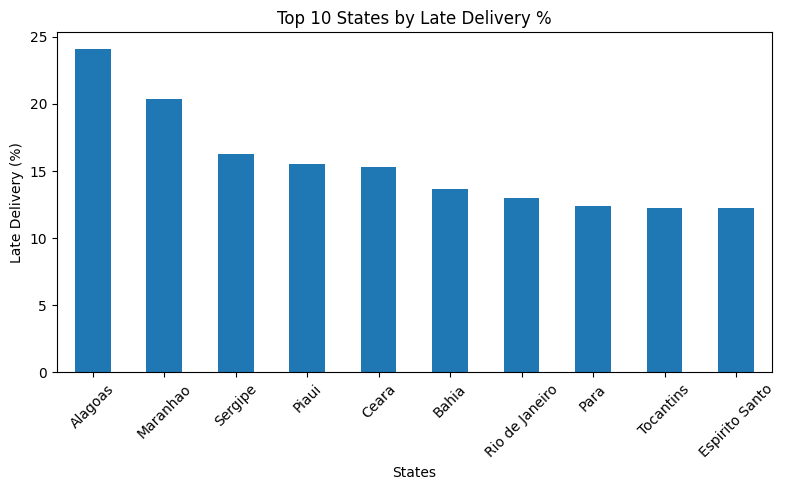

In [49]:
# Visualization

plt.figure(figsize=(8,5))
late_by_state.head(10).plot(kind='bar')
plt.title("Top 10 States by Late Delivery %")
plt.xlabel("States")
plt.ylabel("Late Delivery (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ➔ Insights
---
Late delivery rates vary geographically. 
Certain states exhibit higher delay percentages, 
while major revenue-driving states maintain relatively stable performance.
This suggests region-specific logistics inefficiencies.


### ◆ Which States Generate the Highest Revenue?
---

This analysis identifies geographic revenue concentration 
by calculating total revenue generated per state.



In [ ]:
# Merge all necessary tables
df1 = order_items.merge(orders, on = 'order_id', how = 'left')
df2 = df1.merge(customers, on = 'customer_id', how = 'left')
# Create total revenue
df2['total_revenue'] = df2['price'] + df2['freight_value']
# Calculate revenue by state
revenue_by_states = df2.groupby('customer_state')['total_revenue'].sum().sort_values(ascending = False).head(10)
revenue_by_states = revenue_by_states.reset_index()
revenue_by_states['state_full'] = revenue_by_states['customer_state'].map(state_map)
print(revenue_by_states)

  customer_state  total_revenue         state_full
0             SP     5921678.12          Sao Paulo
1             RJ     2129681.98     Rio de Janeiro
2             MG     1856161.49       Minas Gerais
3             RS      885826.76  Rio Grande do Sul
4             PR      800935.44             Parana
5             BA      611506.67              Bahia
6             SC      610213.60     Santa Catarina
7             DF      353229.44   Distrito Federal
8             GO      347706.93              Goias
9             ES      324801.91     Espirito Santo


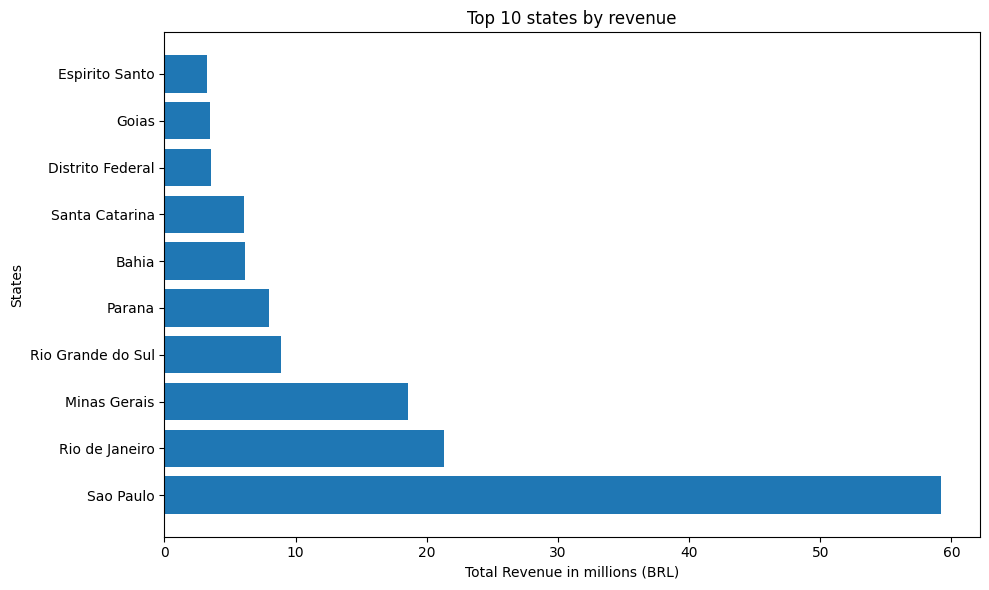

In [45]:
# Visualization

revenue_by_states['revenue_million'] = revenue_by_states['total_revenue'] / 100000
plt.figure(figsize = (10, 6))
plt.barh(revenue_by_states['state_full'], revenue_by_states['revenue_million'])
plt.xlabel("Total Revenue in millions (BRL)")
plt.ylabel("States")
plt.title("Top 10 states by revenue")
plt.ticklabel_format(style = 'plain', axis = 'x')
plt.tight_layout()
plt.show()

### ➔ Insights
---
Revenue is concentrated in major economic hubs, 
with São Paulo (SP) leading significantly. 
The top-performing states contribute a substantial 
portion of total company revenue, indicating geographic concentration.

### ◆ How Much Revenue Comes from Delivered Orders?
----
This analysis measures revenue realization efficiency 
by calculating the proportion of revenue from successfully delivered orders.

In [50]:
# Total revenuetotal_revenue = df['total_revenue'].sum()
# Revenue from delivered orders
delivered_revenue = (df[df['order_status'] == 'delivered']['total_revenue'].sum())
# Percentage realized
revenue_realization = (delivered_revenue / total_revenue) * 100
print(total_revenue, delivered_revenue, revenue_realization)

15843553.24 15419773.75 97.3252244393632


### ➔ Insights
---
Approximately **97.3%** of total revenue is derived from successfully 
delivered orders, indicating strong fulfillment reliability.
Revenue loss due to cancellations or non-delivery remains minimal.


## ► Final Conclusion
---
This analysis provides a comprehensive overview of business performance 
across revenue growth, customer behavior, and logistics efficiency.

Key findings include:

- Revenue demonstrates stable growth with seasonal spikes.
- Top 20% of customers contribute ~54% of total revenue.
- Repeat purchase rate (~3.12%) indicates retention opportunity.
- Average delivery time is ~12 days with 8.11% late deliveries.
- 97.3% of revenue is successfully realized through delivered orders.
- Revenue is geographically concentrated in major economic hubs.

Overall, the business shows strong revenue realization and operational stability, 
with primary opportunities in customer retention and targeted logistics optimization.
